# Modeling and Evaluation

In this notebook, I train my classifiers and evaluate their efficacy. Then I attempt to improve my models with hyperparameter tuning. The classifiers I will be building are:
- Logistic Regression
- Decision Tree
- Random Forest
- Support Vector Machine (SVM)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [2]:
# Load cleaned data
train = pd.read_csv('../data/final/train_cleaned.csv')
test_features = pd.read_csv('../data/final/test_cleaned.csv')

In [3]:
train_features = train.drop('target', axis=1)
train_target = train['target']

---

## Dropping Unneeded Columns

In [4]:
# Unneeded and redundant columns to drop
columns_to_drop = ['id', 'wpt_name', 'num_private', 'subvillage', 'ward', 'recorded_by', 'scheme_name', 
                    'scheme_management', 'water_quality', 'waterpoint_type_group', 'quantity_group', 'region_code', 
                    'extraction_type', 'extraction_type_group', 'payment', 'source_class', 'source_type',
                    'funder', 'installer', 'longitude', 'latitude', 'date_recorded', 'construction_year',
                    'district_code']

In [5]:
train_features = train_features.drop(columns=columns_to_drop)
test_features = test_features.drop(columns=columns_to_drop)

In [6]:
train_features.shape, test_features.shape

((59400, 18), (14850, 18))

## Encoding Target

0: <code>functional</code>: pump is functional

1: <code>non-functional</code>: pump is not functional

In [7]:
train_target = train_target.map({'functional': 0, 'non functional': 1})
train_target.value_counts()

target
0    32259
1    27141
Name: count, dtype: int64

## Encoding Features

Categorical features need to be encoded before being fed into classification algorithms. 

In [8]:
# Import packages for categorical encoding
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from category_encoders import OrdinalEncoder
from category_encoders import CountEncoder
from category_encoders import HashingEncoder
from category_encoders import BackwardDifferenceEncoder
from category_encoders import HelmertEncoder
from category_encoders import CatBoostEncoder
from category_encoders import GLMMEncoder

The following encoding methods will be used:
- <code>OrdinalEncoder()</code>: converts categorical variables to ordered numerical values
- <code>CountEncoder()</code>: replaces each categorical variable with its frequency count in the column
- <code>HashingEncoder()</code>: hashes categorical variables to unique one-hot vectors with configurable dimensionality
- <code>BackwardDifferenceEncoder()</code>: the mean of the $k_{th}$ categorical variable is compared with the mean of the $k_{th}-1$
- <code>Helmert Encoding()</code>: the mean of the $k_{th}$ categorical variable is compared with the means of all previous categorical variables
- <code>CatBoostEncoding()</code>: similar to <code>TargetEncoder</code> which converts each categorical value with the mean appearance of its target, but also involves an ordering principle in order to overcome the "Target Leakage" problem
- <code>GLMMEncoder()</code>: Generalized Linear Mixed Model - A supervised encoder similar to <code>TargetEncoder</code>, but solid statistical theory is also included. The advantage over other supervised encoders is that no parameter tuning is needed

In [9]:
# Encoding methods
random_state = 42

encoding_methods = {
    'ordinal': OrdinalEncoder(),
    'count': CountEncoder(),
    'hashing': HashingEncoder(n_components=32, drop_invariant=True),
    'backward_difference': BackwardDifferenceEncoder(),
    'Helmert': HelmertEncoder(),
    'CatBoost': CatBoostEncoder(random_state=random_state),
    'GLMM': GLMMEncoder(random_state=random_state)
}

## Training Classifiers

Let's train some classification algorithms in their default state with no tuning. I will then pick the model with the higest accuracy score and proceed with hyperparameter tuning for that model. I've chosen accuracy score as the initial main evaluation metric because the classes are fairly balanced and the problem does not demand specific attention to true positives or true negatives. I'm interested in the overall correct predictions. 

Also, the goal of the online competition where I got this dataset from is to build a model with the highest accuracy.

In [10]:
# Classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=10000, n_jobs=-1, random_state=random_state),
    'Decision Tree': DecisionTreeClassifier(random_state=random_state),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(random_state=random_state, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=random_state, n_jobs=-1),
    #'Support Vector Machine': SVC(random_state=random_state)
}

In [27]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(train_features, train_target, test_size=0.2, random_state=random_state)

The following nested loop goes through each categorical variable encoding method in <code>encoding_methods</code> and trains all classifier algorithms in <code>classifiers</code> for every encoding method. In the end it returns the pipelines with highest accuracy scores - one pipeline per classifier.

In [12]:
classifier_best_results = {classifier_name: (0, 'encoder') for classifier_name in classifiers.keys()}


for encoding_method, encoder in encoding_methods.items():
    print(f'\n----- Encoding data using {encoding_method} Encoder -----', end='')

    start_time = time.time()

    encoded_X_train = encoder.fit_transform(X_train, y_train)
    encoded_X_test = encoder.transform(X_test)

    end_time = time.time()
    print(f'Done in {round(end_time-start_time, 2)}s')

    for classifier_name, clf_algorithm in classifiers.items():
        print(f'Training {classifier_name} Classifier', end='')

        start_time = time.time()

        clf_algorithm.fit(encoded_X_train, y_train)
        y_pred = clf_algorithm.predict(encoded_X_test)
        acc = accuracy_score(y_test, y_pred)

        end_time = time.time()
        print(f'Done in {round(end_time-start_time, 2)}s')

        previous_acc, _ = classifier_best_results[classifier_name]
        if previous_acc < acc:
            classifier_best_results[classifier_name] = (acc, encoding_method)


for classifier_name, (score, encoding_method) in classifier_best_results.items():
    print(f'\nClassifier: {classifier_name}\tBest Score: {score} on Test Data\t Using {encoding_method} Encoder')


----- Encoding data using ordinal Encoder -----Done in 0.19s
Training Logistic Regression ClassifierDone in 10.1s
Training Decision Tree ClassifierDone in 0.19s
Training Naive Bayes ClassifierDone in 0.01s
Training Random Forest ClassifierDone in 0.7s
Training XGBoost ClassifierDone in 0.18s

----- Encoding data using count Encoder -----Done in 0.28s
Training Logistic Regression Classifier

/opt/anaconda3/envs/learn-env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Done in 14.46s
Training Decision Tree ClassifierDone in 0.2s
Training Naive Bayes ClassifierDone in 0.01s
Training Random Forest ClassifierDone in 0.79s
Training XGBoost ClassifierDone in 0.18s

----- Encoding data using hashing Encoder -----Done in 0.48s
Training Logistic Regression ClassifierDone in 8.87s
Training Decision Tree ClassifierDone in 0.23s
Training Naive Bayes ClassifierDone in 0.02s
Training Random Forest ClassifierDone in 0.68s
Training XGBoost ClassifierDone in 0.21s

----- Encoding data using backward_difference Encoder -----

/opt/anaconda3/envs/learn-env/lib/python3.12/site-packages/category_encoders/base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",
/opt/anaconda3/envs/learn-env/lib/python3.12/site-packages/category_encoders/base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",
/opt/anaconda3/envs/learn-env/lib/python3.12/site-packages/category_encoders/base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",


Done in 0.96s
Training Logistic Regression Classifier

/opt/anaconda3/envs/learn-env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Done in 49.89s
Training Decision Tree ClassifierDone in 0.71s
Training Naive Bayes ClassifierDone in 0.09s
Training Random Forest ClassifierDone in 1.43s
Training XGBoost ClassifierDone in 0.49s

----- Encoding data using Helmert Encoder -----

/opt/anaconda3/envs/learn-env/lib/python3.12/site-packages/category_encoders/base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",
/opt/anaconda3/envs/learn-env/lib/python3.12/site-packages/category_encoders/base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",
/opt/anaconda3/envs/learn-env/lib/python3.12/site-packages/category_encoders/base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",


Done in 0.88s
Training Logistic Regression ClassifierDone in 50.99s
Training Decision Tree ClassifierDone in 0.98s
Training Naive Bayes ClassifierDone in 0.1s
Training Random Forest ClassifierDone in 1.64s
Training XGBoost ClassifierDone in 0.42s

----- Encoding data using CatBoost Encoder -----Done in 0.19s
Training Logistic Regression Classifier

/opt/anaconda3/envs/learn-env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Done in 14.6s
Training Decision Tree ClassifierDone in 0.9s
Training Naive Bayes ClassifierDone in 0.01s
Training Random Forest ClassifierDone in 2.6s
Training XGBoost ClassifierDone in 0.24s

----- Encoding data using GLMM Encoder -----Done in 20.48s
Training Logistic Regression ClassifierDone in 7.77s
Training Decision Tree ClassifierDone in 0.19s
Training Naive Bayes ClassifierDone in 0.01s
Training Random Forest ClassifierDone in 0.71s
Training XGBoost ClassifierDone in 0.18s

Classifier: Logistic Regression	Best Score: 0.7662457912457913 on Test Data	 Using Helmert Encoder

Classifier: Decision Tree	Best Score: 0.7792087542087542 on Test Data	 Using Helmert Encoder

Classifier: Naive Bayes	Best Score: 0.7301346801346801 on Test Data	 Using CatBoost Encoder

Classifier: Random Forest	Best Score: 0.8118686868686869 on Test Data	 Using GLMM Encoder

Classifier: XGBoost	Best Score: 0.8096801346801347 on Test Data	 Using count Encoder


The pipeline of a Random Forest classifier using a GLMM encoder for feature encoding yields the highest accuracy score with XGBoost + CountEncoder following closely behind. While the goal of the competition is to get the highest accuracy score possible, due to a slight imbalance in the target variable (even after merging the smallest class into one of the big classes) a full classification report for the "best" models above can provide valuable insights.

## Classification Reports

In [13]:
# Getting the classification reports for the highest scoring models
scores = []
pipelines = []

for classifier_name, metric in classifier_best_results.items():
    score, encoding_method = metric
    encoder = encoding_methods[encoding_method]
    encoded_X_train = encoder.fit_transform(X_train, y_train)
    encoded_X_test = encoder.transform(X_test)

    clf = classifiers[classifier_name]
    clf.fit(encoded_X_train, y_train)
    y_pred = clf.predict(encoded_X_test)

    scores.append(score)
    pipelines.append(classifier_name + ' - ' + encoding_method)

    print(f'\n-----Classifier: {classifier_name}\tEncoding: {encoding_method}-----')
    print(classification_report(y_test, y_pred))

/opt/anaconda3/envs/learn-env/lib/python3.12/site-packages/category_encoders/base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",
/opt/anaconda3/envs/learn-env/lib/python3.12/site-packages/category_encoders/base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",
/opt/anaconda3/envs/learn-env/lib/python3.12/site-packages/category_encoders/base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",



-----Classifier: Logistic Regression	Encoding: Helmert-----
              precision    recall  f1-score   support

           0       0.75      0.85      0.80      6457
           1       0.79      0.66      0.72      5423

    accuracy                           0.77     11880
   macro avg       0.77      0.76      0.76     11880
weighted avg       0.77      0.77      0.76     11880



/opt/anaconda3/envs/learn-env/lib/python3.12/site-packages/category_encoders/base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",
/opt/anaconda3/envs/learn-env/lib/python3.12/site-packages/category_encoders/base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",
/opt/anaconda3/envs/learn-env/lib/python3.12/site-packages/category_encoders/base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",



-----Classifier: Decision Tree	Encoding: Helmert-----
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      6457
           1       0.76      0.75      0.76      5423

    accuracy                           0.78     11880
   macro avg       0.78      0.78      0.78     11880
weighted avg       0.78      0.78      0.78     11880


-----Classifier: Naive Bayes	Encoding: CatBoost-----
              precision    recall  f1-score   support

           0       0.71      0.85      0.77      6457
           1       0.77      0.59      0.67      5423

    accuracy                           0.73     11880
   macro avg       0.74      0.72      0.72     11880
weighted avg       0.74      0.73      0.72     11880


-----Classifier: Random Forest	Encoding: GLMM-----
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      6457
           1       0.81      0.77      0.79      5423

    accuracy         

## Hyperparameter Tuning for Random Forest Model

In [15]:
# Optuna, an automatic hyperparameter optimization software framework
import optuna

In [20]:
# Creating a function to optimize the hyperparameters of my Random Forest classifier in order to maximize accuracy

n_trials = 30

encoder = GLMMEncoder()
X_train = encoder.fit_transform(train_features, train_target)

def rf_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    optimizer = trial.suggest_categorical('optimizer', ['gini', 'entropy', 'log_loss'])
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, criterion=optimizer)
    avg_acc = cross_val_score(rf_clf, X_train, train_target, cv=10, n_jobs=-1).mean()
    return avg_acc


rf_study = optuna.create_study(direction='maximize')
rf_study.optimize(rf_objective, n_trials=n_trials)
rf_study.trials_dataframe()

[I 2024-10-28 02:30:27,245] A new study created in memory with name: no-name-bea90524-edcd-4b7c-b338-376b567f8cd1
[I 2024-10-28 02:30:51,431] Trial 0 finished with value: 0.8122558922558921 and parameters: {'n_estimators': 167, 'optimizer': 'log_loss'}. Best is trial 0 with value: 0.8122558922558921.
[I 2024-10-28 02:31:59,031] Trial 1 finished with value: 0.8137037037037036 and parameters: {'n_estimators': 497, 'optimizer': 'entropy'}. Best is trial 1 with value: 0.8137037037037036.
[I 2024-10-28 02:32:33,017] Trial 2 finished with value: 0.8133838383838384 and parameters: {'n_estimators': 242, 'optimizer': 'log_loss'}. Best is trial 1 with value: 0.8137037037037036.
[I 2024-10-28 02:33:01,674] Trial 3 finished with value: 0.8133838383838382 and parameters: {'n_estimators': 221, 'optimizer': 'log_loss'}. Best is trial 1 with value: 0.8137037037037036.
[I 2024-10-28 02:33:30,111] Trial 4 finished with value: 0.8131986531986533 and parameters: {'n_estimators': 232, 'optimizer': 'entropy

,number,value,datetime_start,datetime_complete,duration,params_n_estimators,params_optimizer,state
0,0,0.812256,2024-10-28 02:30:27.246653,2024-10-28 02:30:51.430846,0 days 00:00:24.184193,167,log_loss,COMPLETE
1,1,0.813704,2024-10-28 02:30:51.433244,2024-10-28 02:31:59.031249,0 days 00:01:07.598005,497,entropy,COMPLETE
2,2,0.813384,2024-10-28 02:31:59.034776,2024-10-28 02:32:33.017523,0 days 00:00:33.982747,242,log_loss,COMPLETE
3,3,0.813384,2024-10-28 02:32:33.019912,2024-10-28 02:33:01.674406,0 days 00:00:28.654494,221,log_loss,COMPLETE
4,4,0.813199,2024-10-28 02:33:01.677787,2024-10-28 02:33:30.111581,0 days 00:00:28.433794,232,entropy,COMPLETE
5,5,0.813350,2024-10-28 02:33:30.113691,2024-10-28 02:34:08.249857,0 days 00:00:38.136166,334,gini,COMPLETE
6,6,0.811970,2024-10-28 02:34:08.251709,2024-10-28 02:34:18.603964,0 days 00:00:10.352255,89,gini,COMPLETE
7,7,0.813552,2024-10-28 02:34:18.605851,2024-10-28 02:34:50.083132,0 days 00:00:31.477281,260,entropy,COMPLETE
8,8,0.813519,2024-10-28 02:34:50.090300,2024-10-28 02:35:17.374275,0 days 00:00:27.283975,242,gini,COMPLETE
9,9,0.813434,2024-10-28 02:35:17.376574,2024-10-28 02:35:35.494655,0 days 00:00:18.118081,150,entropy,COMPLETE


In the interest of time I set the number of trials to just 30 and obtained the above results.

In [21]:
optuna.visualization.plot_contour(rf_study, params=['n_estimators', 'optimizer'])

In [22]:
optuna.visualization.plot_param_importances(rf_study)


The Random Forest classifier with the best accuracy score has the following parameters:

In [23]:
# Trial at index 16 (17th trial) has the highest accuracy of 0.814024
rf_study.best_params

{'n_estimators': 432, 'optimizer': 'entropy'}

## Default vs Tuned Random Forest Model

In [34]:
def confusion_matrix_plotter (y_test, y_pred):
  fig, ax = plt.subplots(figsize=(8,5)) 
  data = confusion_matrix(y_test, y_pred)
  df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
  ax = sns.heatmap(df_cm, cmap='Blues', fmt='g' ,annot=True,annot_kws={"size": 14})
  ax.set_xlabel("Predicted")
  ax.set_ylabel ("Actual")
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
  ax.set_yticklabels(ax.get_xticklabels(), rotation=0)

In [35]:
def feature_importances (model, title):
  features= X_train.columns
  importances = np.round(model.feature_importances_,3) 
  indices = np.argsort(importances)
  num_features = len(features)
  fig, ax = plt.subplots(figsize=(10,10)) 
  plt.barh(range(num_features), importances[indices[-num_features:]],  align='center', color =  '#66c2a5')
  plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
  plt.xlabel('Relative Importance')
  plt.title('Feature Importance'+ title)
plt.show()

In [24]:
# Default parameters
rf = RandomForestClassifier(random_state=random_state, n_jobs=-1)

# Tuned parameters
tuned_rf = RandomForestClassifier(n_estimators=432, criterion='entropy', random_state=random_state, n_jobs=-1)

In [29]:
encoder = GLMMEncoder()
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

### Default RF Model

In [40]:
# Default RF
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Default Random Forest Classifier Accuracy: {acc}')

Default Random Forest Classifier Accuracy: 0.8118686868686869


In [41]:
# Train accuracy
rf.score(X_train, y_train)

0.9662878787878788

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      6457
           1       0.81      0.77      0.79      5423

    accuracy                           0.81     11880
   macro avg       0.81      0.81      0.81     11880
weighted avg       0.81      0.81      0.81     11880



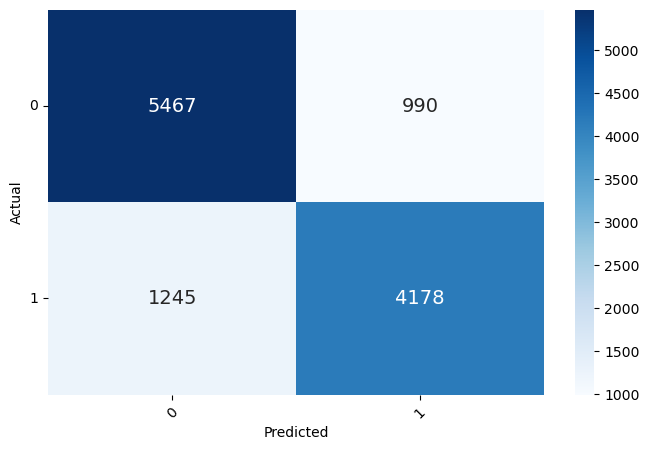

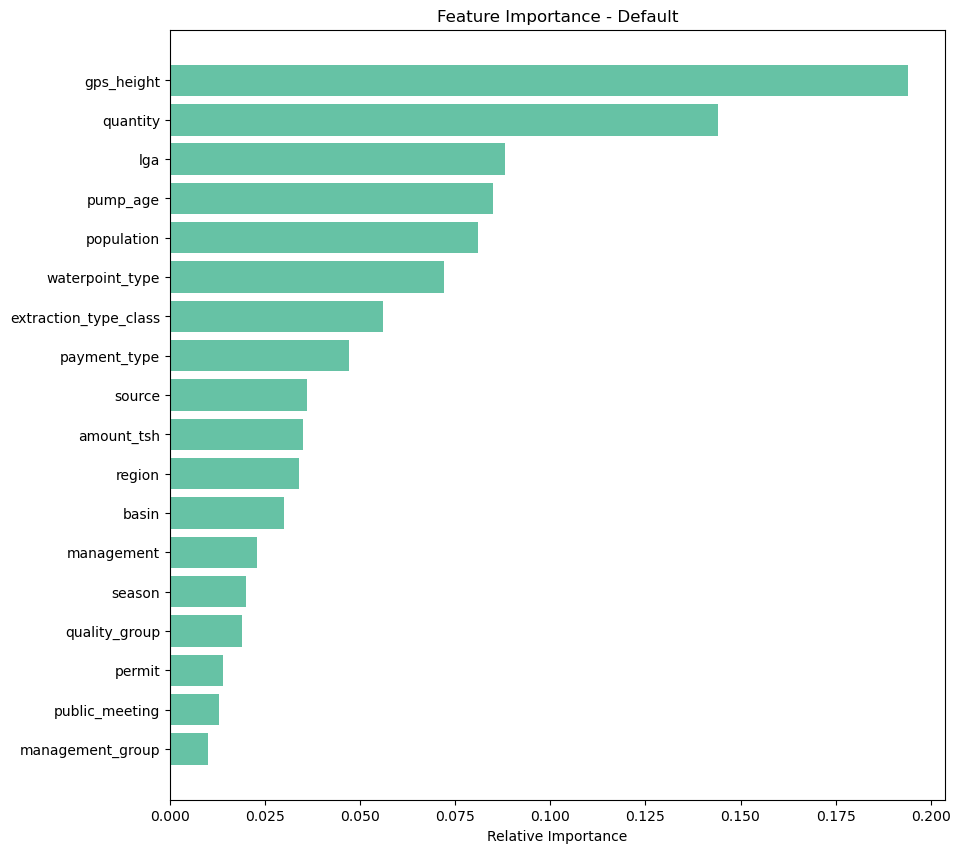

In [37]:
print(classification_report(y_test, y_pred))
confusion_matrix_plotter(y_test, y_pred)
feature_importances(rf, ' - Default')

### Tuned RF Model

In [42]:
# Tuned RF
tuned_rf.fit(X_train, y_train)
y_pred = tuned_rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Tuned Random Forest Classifier Accuracy: {acc}')

Tuned Random Forest Classifier Accuracy: 0.8134680134680135


In [43]:
# Tune RF train accuracy
tuned_rf.score(X_train, y_train)

0.9663510101010101

              precision    recall  f1-score   support

           0       0.82      0.85      0.83      6457
           1       0.81      0.77      0.79      5423

    accuracy                           0.81     11880
   macro avg       0.81      0.81      0.81     11880
weighted avg       0.81      0.81      0.81     11880



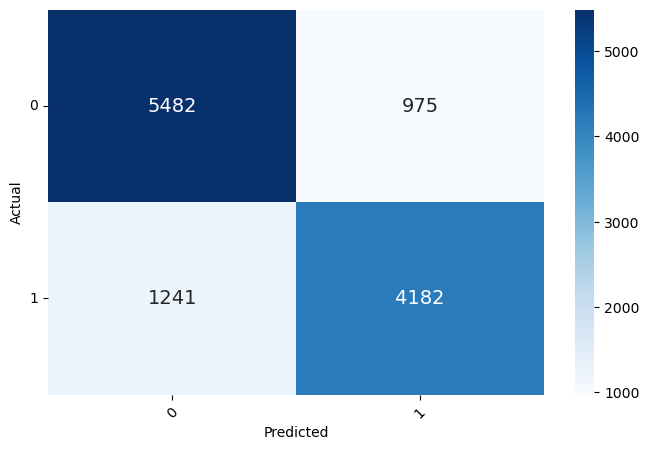

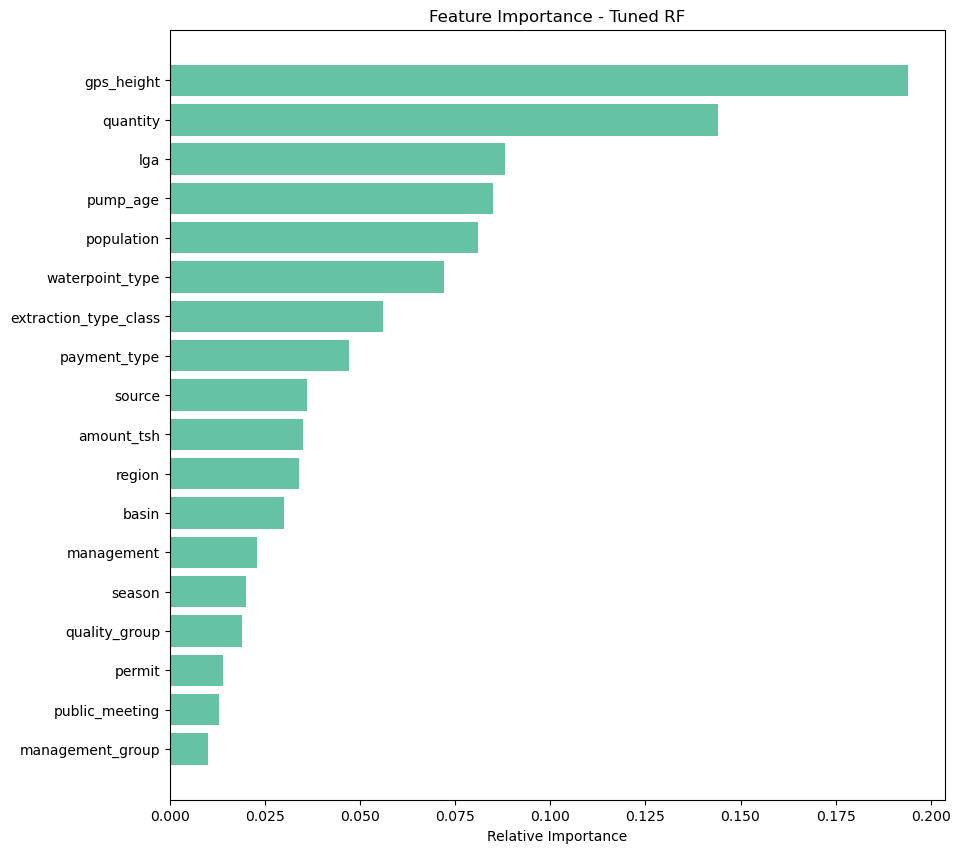

In [39]:
print(classification_report(y_test, y_pred))
confusion_matrix_plotter(y_test, y_pred)
feature_importances(rf, ' - Tuned RF')